In [54]:
import sys; sys.path.append("../")
from src.GeneratingModels import SimulatedReactionGraph
from src.KineticSolver import KineticSolver
from src import constants
from src.NasaPolynomial import NasaPolynomial
import torinanet as tn
from scipy.interpolate import interp1d
import numpy as np
import ruptures as rpt
from typing import Union, List
import json
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
percolation_df = pd.read_csv("../results/percolation.csv", index_col=0)
percolation_df["id"]= ["s{}r{}/{}/{}".format(s, r, rep, prep) for s, r, rep, prep in percolation_df[["og_reactions", "og_species", "rep", "percolation_rep"]].values]
percolation_df

,rg_reactions,rg_species,conc_profile_error,conc_ss_error,rate_profile_error,max_rate_error,min_coverage,mean_coverage,ss_coverage,max_rate_coverage,og_reactions,og_species,rep,percolation_rep,percolation_step_size,total_percolated,id
0,2475,50,6.298076e-07,4.768391e-07,2.397070e+03,4.944220e+04,9.999994e-01,1.000000e+00,1.000000e+00,9.999998e-01,2500,50,0,1,25,25,s2500r50/0/1
1,2450,50,6.272873e-07,4.781567e-07,2.419011e+03,5.008514e+04,9.999994e-01,1.000000e+00,9.999999e-01,9.999998e-01,2500,50,0,1,25,50,s2500r50/0/1
2,2425,50,3.235350e-03,3.678654e-03,1.086758e+06,1.744165e+07,8.866201e-01,9.866049e-01,9.999996e-01,9.935357e-01,2500,50,0,1,25,75,s2500r50/0/1
3,2400,50,3.234735e-03,3.678284e-03,1.099081e+06,1.762437e+07,8.866201e-01,9.866048e-01,9.999996e-01,9.935356e-01,2500,50,0,1,25,100,s2500r50/0/1
4,2375,50,3.235109e-03,3.678272e-03,1.109702e+06,1.780955e+07,8.866201e-01,9.866048e-01,9.999996e-01,9.935356e-01,2500,50,0,1,25,125,s2500r50/0/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,152,24,0.000000e+00,1.891216e+18,0.000000e+00,6.324460e+31,4.360550e-31,2.559502e-03,3.497551e-07,3.497551e-07,2500,25,3,2,25,2275,s2500r25/3/2
3669,127,24,0.000000e+00,1.891216e+18,0.000000e+00,7.569432e+31,4.360550e-31,2.558785e-03,3.497551e-07,3.497551e-07,2500,25,3,2,25,2300,s2500r25/3/2
3670,79,23,0.000000e+00,1.973442e+18,0.000000e+00,1.216858e+32,4.360550e-31,3.005261e-07,3.497551e-07,3.497551e-07,2500,25,3,2,25,2325,s2500r25/3/2
3671,54,22,0.000000e+00,2.063144e+18,0.000000e+00,1.209942e+32,4.360550e-31,2.024607e-07,2.377143e-07,2.377143e-07,2500,25,3,2,25,2350,s2500r25/3/2


In [165]:
def detect_peaks(x: list):
    """detect the first peak using Dixon's q-test"""
    # list of critical values (from wikipedia)
    critical_values = {
        0.90: [0.941, 0.765, 0.642, 0.560, 0.507, 0.468, 0.437, 0.412],
        0.95: [0.970, 0.829, 0.710, 0.625, 0.568, 0.526, 0.493, 0.466],
        0.99: [0.994, 0.926, 0.821, 0.740, 0.680, 0.634, 0.598, 0.568],
    }
    confidence = 0.99 # we use 99% confidence, after some testing it seems to be best
    sample = list(x[:2])
    for i, s in enumerate(x[2:]):
        if min(sample) <= s <= max(sample):
            sample.append(s)
        q = min(abs(s - min(sample)) / (max(sample) - min(sample)), abs(s - max(sample)) / (max(sample) - min(sample)))
        sample.append(s)
        # Compare to tabulated Dixon Q statistic for a given confidence level
        n = len(sample)
        if n > 3:  # Dixon Q test is applicable for n > 3
            q_critical = critical_values[confidence][min(7, n - 3)]
            if q > q_critical:
                return i + 2  # Return the sample excluding the outlier
    # returns None if no peak found

def collect_peak_data(df, id_column, step_size_col, cols): 
    """Collect all peak data on given columns"""
    data = []
    idxs = df[id_column].unique()
    for idx in idxs:
        ajr = df[df[id_column] == idx]
        stepsize = ajr[step_size_col].min()
        res = {}
        for c in cols:
            peak = detect_peaks(ajr[c].values)
            res[c] = (peak + 1) * stepsize if peak is not None else None
        data.append(res)
    return pd.DataFrame(data, index=idxs)


In [188]:
# collect data
columns = ["ss_coverage", "max_rate_coverage", "conc_profile_error", "conc_ss_error", "rate_profile_error", "max_rate_error"]
df = collect_peak_data(percolation_df, "id", "percolation_step_size", columns)
df["max_ss_coverage"] = [percolation_df[percolation_df["id"] == idx]["ss_coverage"].max() for idx in df.index]
df["max_max_rate_coverage"] = [percolation_df[percolation_df["id"] == idx]["max_rate_coverage"].max() for idx in df.index]
df["base_ss_coverage"] = [percolation_df[(percolation_df["id"] == idx) & (percolation_df["total_percolated"] <= df.loc[idx, "ss_coverage"])]["ss_coverage"].min() for idx in df.index]
df["base_max_rate_coverage"] = [percolation_df[(percolation_df["id"] == idx) & (percolation_df["total_percolated"] <= df.loc[idx, "max_rate_coverage"])]["max_rate_coverage"].min() for idx in df.index]
print("max rate coverage", df["base_max_rate_coverage"].mean(), df["base_max_rate_coverage"].median(), df["max_rate_coverage"].median(), df["max_rate_coverage"].mean())
print("ss coverage", df["base_ss_coverage"].mean(), df["base_ss_coverage"].median(), df["ss_coverage"].median(), df["ss_coverage"].mean())

/tmp/ipykernel_9628/566043306.py:14: RuntimeWarning: invalid value encountered in scalar divide
  q = min(abs(s - min(sample)) / (max(sample) - min(sample)), abs(s - max(sample)) / (max(sample) - min(sample)))
/tmp/ipykernel_9628/566043306.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  q = min(abs(s - min(sample)) / (max(sample) - min(sample)), abs(s - max(sample)) / (max(sample) - min(sample)))


max rate coverage 0.9433739778966533 0.9991556356567772 150.0 218.4313725490196
ss coverage 0.9249066138241006 0.9940885719573568 200.0 228.6734693877551


,ss_coverage,max_rate_coverage,conc_profile_error,conc_ss_error,rate_profile_error,max_rate_error,max_ss_coverage,max_max_rate_coverage,base_ss_coverage,base_max_rate_coverage
ss_coverage,1.000000,0.340192,0.243462,0.239950,0.210923,8.740496e-02,0.000678,1.306634e-02,0.000785,0.036420
max_rate_coverage,0.340192,1.000000,0.861119,0.584792,0.770920,2.587501e-01,0.006124,5.649845e-03,0.003497,0.201260
conc_profile_error,0.243462,0.861119,1.000000,0.916666,0.800330,2.235188e-01,0.000216,4.644456e-03,0.000014,0.177775
conc_ss_error,0.239950,0.584792,0.916666,1.000000,0.764403,7.144857e-01,0.006890,4.518515e-03,0.000316,0.172923
rate_profile_error,0.210923,0.770920,0.800330,0.764403,1.000000,4.857451e-01,0.006202,7.032468e-05,0.005224,0.361211
max_rate_error,0.087405,0.258750,0.223519,0.714486,0.485745,1.000000e+00,0.010191,2.690926e-07,0.000013,0.006652
max_ss_coverage,0.000678,0.006124,0.000216,0.006890,0.006202,1.019077e-02,1.000000,2.412101e-05,0.209855,0.009740
max_max_rate_coverage,0.013066,0.005650,0.004644,0.004519,0.000070,2.690926e-07,0.000024,1.000000e+00,0.004744,0.028238
base_ss_coverage,0.000785,0.003497,0.000014,0.000316,0.005224,1.310833e-05,0.209855,4.743520e-03,1.000000,0.000512
base_max_rate_coverage,0.036420,0.201260,0.177775,0.172923,0.361211,6.651757e-03,0.009740,2.823821e-02,0.000512,1.000000


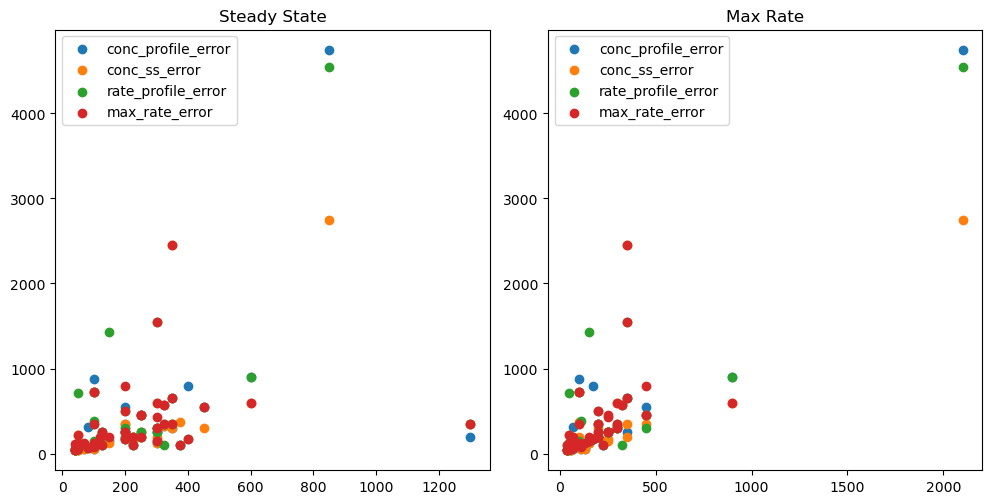

In [186]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plt.tight_layout()
for c in columns[2:]:
    #fdf = df[df["max_ss_coverage"] > 0.999]
    axs[0].scatter(df["ss_coverage"], df[c], label=c)
    axs[0].set_title("Steady State")
    axs[0].legend(loc="upper left")
    #fdf = df[df["max_max_rate_coverage"] > 0.999]
    axs[1].scatter(df["max_rate_coverage"], df[c], label=c)
    axs[1].set_title("Max Rate")
    axs[1].legend(loc="upper left")
# axs[0].set_yscale("log")
# axs[1].set_yscale("log")
# axs[0].set_xscale("log")
# axs[1].set_xscale("log")
df.corr() ** 2

In [ ]:
# plotter for errors & coverage with their spikes
def plot_column_with_peaks(ax, column, ajr):
    color = ax._get_lines.get_next_color()
    ax.scatter(ajr["total_percolated"], ajr[column], color=color, label=column)
    changes = [ajr["percolation_step_size"] * i for i in detect_peaks(ajr[column].values)]
    ymin, ymax = ax.get_ylim()
    ax.vlines(changes, ymin=ymin, ymax=ymax, color=color, linestyle="--")

idxs = list(percolation_df["id"].unique())[:1]

for idx in idxs:
    fig, axs = plt.subplots(nrows=3)
    fig.suptitle(idx)
    plt.tight_layout()
    ajr = percolation_df[percolation_df["id"] == idx]
    plot_column_with_peaks(axs[0], "conc_ss_error", ajr)
    plot_column_with_peaks(axs[0], "conc_profile_error", ajr)
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[0].set_title("Concentration Error")
    plot_column_with_peaks(axs[1], "max_rate_error", ajr)
    plot_column_with_peaks(axs[1], "rate_profile_error", ajr)
    axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[1].set_title("Rate Error")
    # plot_column_with_peaks(axs[2], "mean_coverage", ajr)
    plot_column_with_peaks(axs[2], "ss_coverage", ajr)
    plot_column_with_peaks(axs[2], "max_rate_coverage", ajr)
    axs[2].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[2].set_title("Coverage")
    axs[2].set_xlabel("Total Percolated")


In [2]:
def specie_enthalpy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature)

def calculate_reaction_energy(rxn: tn.core.Reaction):
    return sum([specie_enthalpy(sp, temperature=600) for sp in rxn.products]) - sum([specie_enthalpy(sp, temperature=600) for sp in rxn.reactants])

def solve_kinetics(g: Union[tn.core.RxnGraph, SimulatedReactionGraph], temperature: float, **solver_kwargs):
    if isinstance(g, SimulatedReactionGraph):
        solver = KineticSolver(g, "k")
        # og = np.random.choice(g.get_species(), 2) # set randomly two origin points
        iconcs = [1 if s in s in g.origin else 0 for s in g.get_species()]
        reactions = g.reactions()
    elif isinstance(g, tn.core.RxnGraph):
        solver = tn.analyze.kinetics.KineticAnalyzer(g, "k")
        iconcs = [1 if sp in g.source_species else 0 for sp in g.species]
        reactions = g.reactions
    # add rate constant property
    for rxn in reactions:
        rxn.properties["k"] = rxn.properties["A"] * temperature ** rxn.properties["beta"] * np.exp(- rxn.properties["Ea"] / (temperature * 8.314))
    # solve kinetics
    solver.solve_kinetics(iconcs, **solver_kwargs)
    return solver

def compare_concentrations(osolver: KineticSolver, rsolver: KineticSolver) -> dict:
    """Compare different kinetic solveres of original (o) and reduced/percolated (r) graphs"""
    odf = osolver.concentrations_df()
    rdf = rsolver.concentrations_df()
    # compare concentration values - profile + ss value
    profile_err = 0
    ss_err = 0
    for sp in rdf.columns:
        f = interp1d(rdf.index, rdf[sp], bounds_error=False)
        profile_err += np.sum(np.abs(odf[sp] - f(odf.index)))
        oss = odf[sp].iloc[-1]
        rss = rdf[sp].iloc[-1]
        ss_err += np.abs(oss - rss)
    # calculate average
    nsps = len(rdf.columns)
    profile_err = profile_err / (nsps * len(odf.index))
    ss_err = ss_err / nsps
    # normalize by average conc values
    return {"conc_profile_error": profile_err, "conc_ss_error": ss_err}

def compare_rates(osolver: Union[tn.analyze.kinetics.KineticAnalyzer, KineticSolver], rsolver: Union[tn.analyze.kinetics.KineticAnalyzer, KineticSolver]) -> dict:
    odf = osolver.rates_df()
    rdf = rsolver.rates_df()
    # compare concentration values - profile + ss value
    profile_err = 0
    ss_err = 0
    for rxn in rdf.columns:
        f = interp1d(rdf.index, rdf[rxn], bounds_error=False)
        profile_err += np.sum(np.abs(odf[rxn] - f(odf.index)))
        oss = odf[rxn].max()
        rss = rdf[rxn].max()
        ss_err += np.abs(oss - rss)
    # calculate average
    nsps = len(rdf.columns)
    profile_err = profile_err / (nsps * len(odf.index))
    ss_err = ss_err / nsps
    # normalize by average conc values
    return {"rate_profile_error": profile_err, "rate_max_error": ss_err}


def covered_rate(ogsolver: Union[tn.analyze.kinetics.KineticAnalyzer, KineticSolver], rg: Union[tn.core.RxnGraph, SimulatedReactionGraph]):
    if isinstance(rg, SimulatedReactionGraph):
        reactions = rg.get_reactions()
    elif isinstance(rg, tn.core.RxnGraph):
        reactions = [rg.reaction_collection.get_key(r) for r in rg.reactions]
    rates = ogsolver.rates_df()
    covered = rates.loc[:, reactions].sum(axis=1).values / rates.sum(axis=1).values
    return {"min_coverage": np.min(covered), "mean_coverage": np.mean(covered), "ss_coverage": covered[-1]}


def simulated_apply_energy_th(g: SimulatedReactionGraph, th: float):
    for rxn in g.reactions():
        if rxn.oid in g.g and rxn.properties["energy"] > th:
            g.remove_reaction(rxn.oid)
    return g

def tn_apply_energy_th(g: tn.core.RxnGraph, th: float):
    rxns = list(g.reactions)
    for rxn in rxns:
        if not "energy" in rxn.properties:
            rxn.properties["energy"] = calculate_reaction_energy(rxn)
        if g.has_reaction(rxn) and rxn.properties["energy"] > th:
            g = g.remove_reaction(rxn)
    return g


In [ ]:
og = SimulatedReactionGraph.from_file("../data/simulated/s50r5000/10.json")
solver = solve_kinetics(og, 1000, ss_threshold=1e-8, atol=1e-10, rtol=1e-5)
concs_df = solver.concentrations_df()
rates_df = solver.rates_df()
th = 1e-3
for sp in og.species():
    if sp.oid != "s0":
        if np.mean(sp.properties["concentration"]) > th:
            plt.plot(og.simulation_time, sp.properties["concentration"], label=sp.oid)
plt.legend()
plt.xscale("log")
plt.figure()
print(concs_df)
for sp in concs_df.columns:
    if sp != "s0":
        if concs_df[sp].mean() > th:
            plt.plot(concs_df.index, concs_df[sp], label=sp, linestyle="--")
plt.legend()
plt.xscale("log")
# plt.figure()
# th = 1e5
# for rxn in og.reactions():
#     if np.mean(rxn.properties["rate"]) > th:
#         plt.plot(og.simulation_time, rxn.properties["rate"], label=rxn.oid)
# plt.xscale("log")
# plt.figure()
# for rxn in og.reactions():
#     if np.mean(rxn.properties["rate"]) > th:
#         plt.plot(rates_df.index, rates_df[rxn.oid], label=rxn.oid, linestyle="--")
# plt.xscale("log")
# # plt.yscale('log')

In [ ]:
og = SimulatedReactionGraph.from_file("../data/simulated/s25r2500/7.json")
th = 1e-3
for sp in og.species():
    if sp != "s0":
        if np.mean(sp.properties["concentration"]) > th:
            plt.plot(og.simulation_time, sp.properties["concentration"], label=sp.oid)
plt.legend()
plt.xscale("log")
plt.figure()
th = 1e5
for rxn in og.reactions():
    if np.mean(rxn.properties["rate"]) > th:
        plt.plot(og.simulation_time, rxn.properties["rate"], label=rxn.oid)
plt.xscale("log")
# plt.yscale('log')

In [3]:
og = tn.core.RxnGraph.from_file("../data/literature/hydrogen.rxn", classargs=constants.RXN_GRAPH_PARAMS)
# og = SimulatedReactionGraph.from_file("../data/simulated/s25r1000/26.json")
atol = 1e-10
rtol = 1e-5
ss_th = 1e-8
temperature = 1000
ogsolver = solve_kinetics(og, temperature, atol=atol, rtol=rtol, ss_threshold=ss_th)
data = []
for th in [0.5e6, 1e6]:
    if isinstance(og, SimulatedReactionGraph):
        rg = simulated_apply_energy_th(og, th)
    else:
        rg = tn_apply_energy_th(og, th)
    rgsolver = solve_kinetics(rg, temperature, atol=atol, rtol=rtol, ss_threshold=ss_th)
    d = compare_concentrations(ogsolver, rgsolver)
    d.update(compare_rates(ogsolver, rgsolver))
    d.update(covered_rate(ogsolver, rg))
    d["th"] = th
    d["solver"] = rgsolver
    print(d)
    data.append(d)
df = pd.DataFrame(data)

{'conc_profile_error': 0.005661877612900501, 'conc_ss_error': 0.017534043367015018, 'rate_profile_error': 0.815814810971559, 'rate_max_error': 0.6784902626960088, 'min_coverage': 0.9998802659035397, 'mean_coverage': 0.9999747299074545, 'ss_coverage': 0.9999999120847135, 'th': 500000.0, 'solver': <torinanet.analyze.kinetics.KineticAnalyzer.KineticAnalyzer object at 0x7f3e9fedc150>}
{'conc_profile_error': 0.0, 'conc_ss_error': 0.0, 'rate_profile_error': 0.0, 'rate_max_error': 0.0, 'min_coverage': 1.0, 'mean_coverage': 1.0, 'ss_coverage': 1.0, 'th': 1000000.0, 'solver': <torinanet.analyze.kinetics.KineticAnalyzer.KineticAnalyzer object at 0x7f3ea4107410>}


In [4]:
df

,conc_profile_error,conc_ss_error,rate_profile_error,rate_max_error,min_coverage,mean_coverage,ss_coverage,th,solver
0,0.005662,0.017534,0.815815,0.67849,0.99988,0.999975,1.0,500000.0,<torinanet.analyze.kinetics.KineticAnalyzer.Ki...
1,0.000000,0.000000,0.000000,0.00000,1.00000,1.000000,1.0,1000000.0,<torinanet.analyze.kinetics.KineticAnalyzer.Ki...


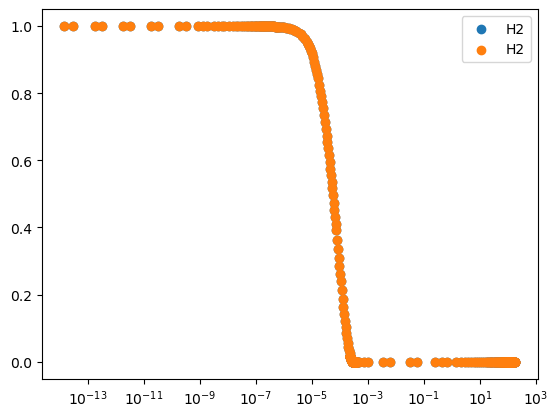

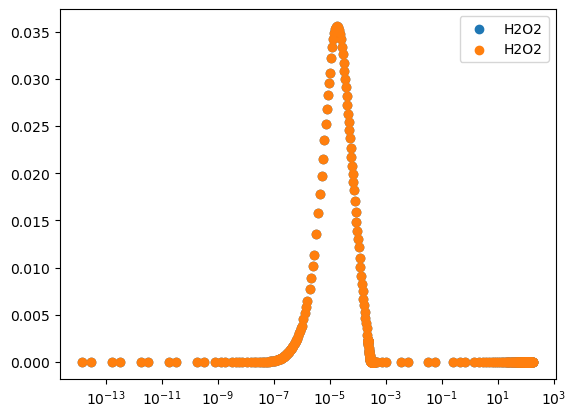

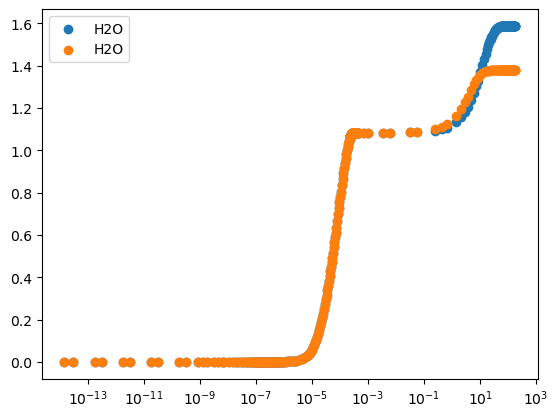

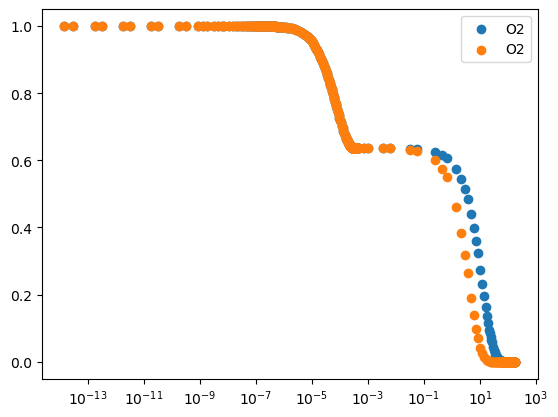

In [5]:
ogconcs = ogsolver.concentrations_df()
rgconcs = df["solver"][0].concentrations_df()
th = 1e-3
for col in rgconcs.columns:
    if rgconcs[col].mean() > th or ogconcs[col].mean() > th:
        plt.figure()
        plt.scatter(rgconcs.index, rgconcs[col].values, label=col)
        f = interp1d(ogconcs.index, ogconcs[col], bounds_error=False, fill_value="extrapolate")
        plt.scatter(rgconcs.index, f(rgconcs.index), label=col)
        plt.legend()
        plt.xscale("log")
        # plt.yscale('log')

In [ ]:
# g = tn.core.RxnGraph.from_file("../data/literature/ammonia.rxn", classargs=constants.RXN_GRAPH_PARAMS)
g = SimulatedReactionGraph.from_file("../data/simulated/s50r2500/0.json")
temp = 1000
for rxn in g.reactions():
    # rxn.properties["k"] = np.exp(rxn.properties["logk"])
    rxn.properties["k"] = rxn.properties["A"] * temp ** rxn.properties["beta"] * np.exp(- rxn.properties["Ea"] / (temp * 8.314))
solver = solve_kinetics(g, atol=1e-8, ss_threshold=1e-8)
rate = [solver.get_max_rate(rxn) for rxn in g.get_reactions()]
# energy = [calculate_reaction_energy(rxn) for rxn in g.get_reactions()]
energy = [rxn.properties["energy"] for rxn in g.reactions()]
df = pd.DataFrame({"rate": rate, "energy": energy})
df = df[df["energy"] >= 0]
plt.scatter(df["energy"], np.log(df["rate"]))

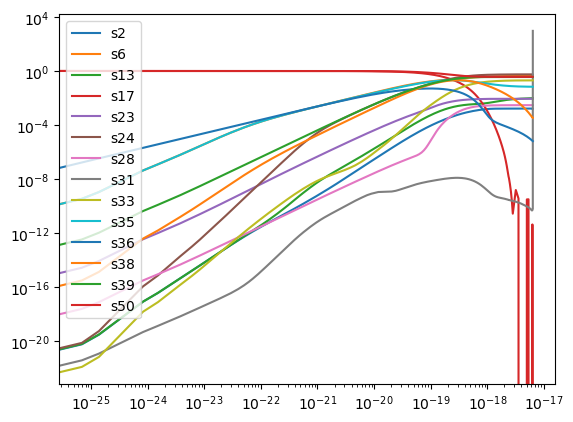

In [15]:
df = solver.concentrations_df()
for col in df.columns:
    if df[col].mean() > 0.001:
        plt.plot(df.index, df[col].values, label=col)
plt.legend()
plt.xscale("log")
plt.yscale('log')

# Reaction Energy Reduction

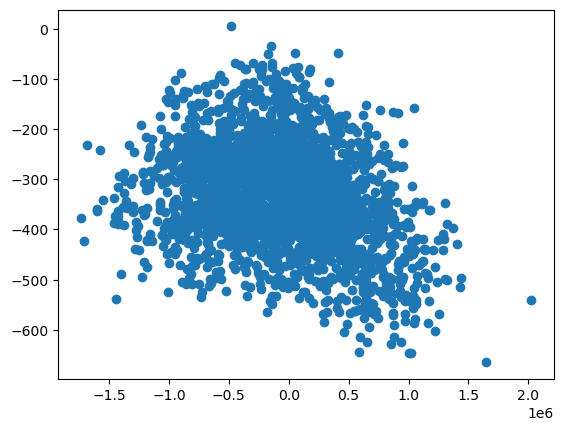

In [ ]:
# show the relation between max reaction rate (or log rate) and reaction energy
g = SimulatedReactionGraph.from_file("../data/simulated/s50r2500/0.json")
solver
rates = [np.log(np.max(g.get_properties(rxn)["rate"])) for rxn in g.get_reactions()]
energies = [g.get_properties(rxn)["energy"] for rxn in g.get_reactions()]
plt.scatter(energies, rates)

In [ ]:
# OLD PICK DETECTORS, we save them for good memories :)
from sklearn.tree import DecisionTreeRegressor

def detect_peaks1(x: list):
    """Detect peaks using a simple relative criteria"""
    peaks = []
    diff = abs(x[1] - x[0])
    for i in range(2, len(x)):
        ndiff = x[i] - x[i - 1]
        # criteria = abs(ndiff) > 100 * diff
        criteria = abs(x[i] / x[i - 1]) > 2
        if criteria and ndiff > 0:
            peaks.append(i + 1)
        diff = abs(ndiff)
    return peaks

def detect_peaks2(x: list):
    """Detect peaks using a simple relative criteria"""
    peaks = []
    diff = abs(x[1] - x[0])
    for i in range(2, len(x)):
        ndiff = x[i] - x[i - 1]
        # criteria = abs(ndiff) > 100 * diff
        criteria = abs(x[i] / x[i - 1]) < 0.99
        if criteria and ndiff < 0:
            peaks.append(i + 1)
        diff = abs(ndiff)
    return peaks


def compute_bic(y_true, y_pred, k):
    n = len(y_true)
    residual_sum_of_squares = np.sum((y_true - y_pred)**2)
    bic = n * np.log(residual_sum_of_squares / n) + k * np.log(n)
    return bic

def tree_detection(x: list):
    t = np.arange(len(x)).reshape(-1, 1)
    bics = []
    models = []
    for n in range(2, 10):
        model = DecisionTreeRegressor(max_leaf_nodes=n)
        model.fit(t, x)
        models.append(model)
        y = model.predict(t)
        bics.append(compute_bic(x, y, n))
    model = models[np.argmin(bics)]
    y = model.predict(t)
    diff = np.diff(y)
    return np.where(diff != 0)[0]
